In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import gzip
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist

In [2]:
X, y = loadlocal_mnist(
    images_path='mnist/train-images.idx3-ubyte', 
    labels_path='mnist/train-labels.idx1-ubyte')

(<matplotlib.image.AxesImage at 0x7703705e0470>, np.uint8(2))

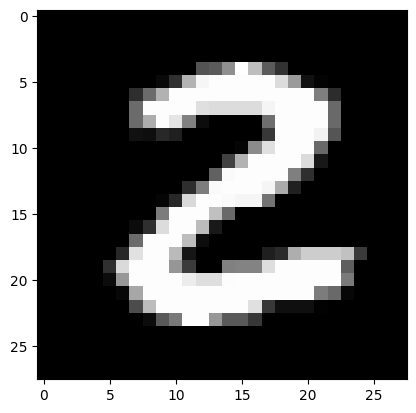

In [3]:
idx = 25
plt.imshow(X[idx, :].reshape(28, 28), cmap='grey'), y[idx]

In [4]:
#data pre-processing
Xtr, ytr = torch.tensor(X).to(torch.float32), torch.tensor(y)
Xtr /= Xtr.mean()

In [5]:
#forward pass conv and max pool
def conv(X, conv, b=None):
    N = X.shape[0] #batch size
    k = conv.shape[-1] #k^2 conv kernel
    C_out = conv.shape[0]
    Xu = F.unfold(X, kernel_size=(k, k)).unsqueeze(dim=1)
    out = torch.matmul(conv.view(C_out, -1), Xu)
    out = out.squeeze(dim=1)
    last_dim = int(np.sqrt(out.shape[-1]))
    out = out.view(N, C_out, last_dim, last_dim) #reshapes to square image, could use fold, or just operate on unfolded shape

    if b != None:
        out += b.view(1, b.shape[0], 1, 1)
    return out

def max_pool(X, w=2):
    pool = X.unfold(2, w, w).unfold(3, w, w)
    max_pool = pool.amax(dim=(-2, -1))
    return max_pool

In [6]:
#hyperparams: learning rate, dropout %, weight of L2 regularization
lr = 0.005
dropout_p = 0.5
l2_reg_lambda = 0.0001

#init params
N = 32 #batch size
C_in = 1 # num color channels
W, H = 28, 28 #image width and height
C_out1 = 6 #number of conv kernels in first conv layer
K1 = 5 #size of conv kernels in first conv layer: KxK
C_out2 = 16
K2 = 3
C_out3 = 120
K3 = 5
N_CLASSES = 10

def init_params():
    C1 = torch.randn(size=(C_out1, C_in, K1, K1)) / K1
    b1 = torch.zeros(size=(C_out1,))
    ga1, bet1 = torch.randn(size=(1, C_out1, 1, 1)), torch.randn(size=(1, C_out1, 1, 1))
    C2 = torch.randn(size=(C_out2, C_out1, K2, K2)) / K2
    b2 = torch.zeros(size=(C_out2,))
    ga2, bet2 = torch.randn(size=(1, C_out2, 1, 1)), torch.randn(size=(1, C_out2, 1, 1))
    C3 = torch.randn(size=(C_out3, C_out2, K3, K3)) / K3
    b3 = torch.zeros(size=(C_out3,))
    ga3, bet3 = torch.randn(size=(1, C_out3, 1, 1)), torch.randn(size=(1, C_out3, 1, 1))
    FC = torch.randn(size=(C_out3, N_CLASSES)) / np.sqrt(C_out3)
    
    #require gradients for params and init optimizer
    params = [C1, b1, ga1, bet1, C2, b2, ga2, bet2, C3, b3, ga3, bet3, FC]
    for p in params:
        p.requires_grad = True
    return params

params = init_params()
C1, b1, ga1, bet1, C2, b2, ga2, bet2, C3, b3, ga3, bet3, FC = params
optimizer = torch.optim.Adam(params, lr=lr)

In [7]:
def forward(X_batch, dropout=True):
    #first conv layer + max pooling
    Xtr_C1 = conv(X_batch, C1, b1)
    mu = Xtr_C1.mean(dim=(0, 2, 3)).view(1, C_out1, 1, 1)
    sig = Xtr_C1.var(dim=(0, 2, 3)).view(1, C_out1, 1, 1) + 1e-5
    Xtr_C1_bnorm = ga1 * ((Xtr_C1 - mu) / sig) + bet1
    Xtr_C1_bnorm = torch.tanh(Xtr_C1_bnorm)
    Xtr_MP1 = max_pool(Xtr_C1_bnorm)

    #apply dropout
    if dropout:
        mask = torch.rand_like(Xtr_MP1)
        Xtr_MP1 = Xtr_MP1 * (mask >= dropout_p) * 1/(1 - dropout_p)
    
    #second conv layer + max pooling
    Xtr_C2 = conv(Xtr_MP1, C2, b2)
    mu = Xtr_C2.mean(dim=(0, 2, 3)).view(1, C_out2, 1, 1)
    sig = Xtr_C2.var(dim=(0, 2, 3)).view(1, C_out2, 1, 1) + 1e-5
    Xtr_C2_bnorm = ga2 * ((Xtr_C2 - mu) / sig) + bet2
    Xtr_C2_bnorm = torch.tanh(Xtr_C2_bnorm)
    Xtr_MP2 = max_pool(Xtr_C2_bnorm)

    if dropout:
        mask = torch.rand_like(Xtr_MP2)
        Xtr_MP2 = Xtr_MP2 * (mask >= dropout_p) * 1/(1 - dropout_p)
    
    #third conv layer, no max pooling
    Xtr_C3 = conv(Xtr_MP2, C3, b3)
    mu = Xtr_C3.mean(dim=(0, 2, 3)).view(1, C_out3, 1, 1)
    sig = Xtr_C3.var(dim=(0, 2, 3)).view(1, C_out3, 1, 1) + 1e-5
    Xtr_C3_bnorm = ga3 * ((Xtr_C3 - mu) / sig) + bet3
    Xtr_C3_bnorm = torch.tanh(Xtr_C3_bnorm)

    if dropout:
        mask = torch.rand_like(Xtr_C3)
        Xtr_C3_bnorm = Xtr_C3_bnorm * (mask >= dropout_p) * 1/(1 - dropout_p)
    
    #fully connected layer
    out = Xtr_C3_bnorm.view(Xtr_C3_bnorm.shape[0], C_out3) @ FC

    return out

In [8]:
N_ITERS = 10
losses = []
for _ in range(N_ITERS):
    #sample from training dataset
    sample_idxs = torch.randperm(Xtr.shape[0])[:N]
    Xtr_batch = Xtr[sample_idxs, :].view(N, C_in, W, H)
    ytr_batch = ytr[sample_idxs]

    out = forward(Xtr_batch)

    #backprop
    optimizer.zero_grad()
    loss = F.cross_entropy(out, ytr_batch) + sum([(p**2).sum() for p in params]) * l2_reg_lambda #CEL + L2 Reg
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

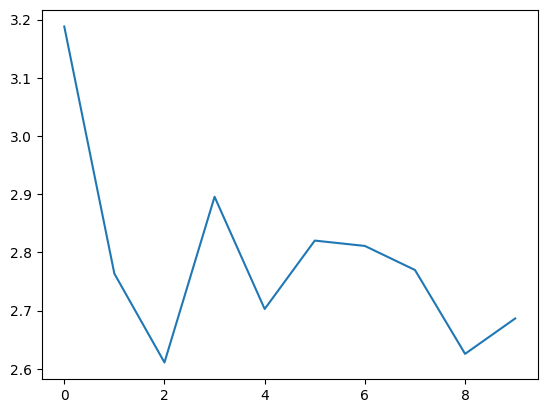

In [9]:
plt.plot(list(range(len(losses))), losses)

In [10]:
#hyperparameter tuning
N_HYPER_SAMPLES = 3
tests = {}
for i in range(N_HYPER_SAMPLES):
    print('running hyperparam sample: ', i)
    lr = 10 ** np.random.uniform(-4, -1)
    dropout_p = np.random.uniform(0.2, 0.8)
    l2_reg_lambda = 10 ** np.random.uniform(-5, -2)
    test_dict = {
        'lr': lr,
        'dropout_p': dropout_p,
        'l2_reg_lambda': l2_reg_lambda
    }
    params = init_params()
    C1, b1, ga1, bet1, C2, b2, ga2, bet2, C3, b3, ga3, bet3, FC = params
    optimizer = torch.optim.Adam(params, lr=lr)

    #run losses
    N_ITERS = 100
    losses = []
    for _ in range(N_ITERS):
        #sample from training dataset
        sample_idxs = torch.randperm(Xtr.shape[0])[:N]
        Xtr_batch = Xtr[sample_idxs, :].view(N, C_in, W, H)
        ytr_batch = ytr[sample_idxs]
    
        out = forward(Xtr_batch)
    
        #backprop
        optimizer.zero_grad()
        loss = F.cross_entropy(out, ytr_batch) + sum([(p**2).sum() for p in params]) * l2_reg_lambda #CEL + L2 Reg
        loss.backward()
        optimizer.step()
    
        losses.append(loss.item())

    test_dict['losses'] = losses
    train_out = forward(Xtr.view(Xtr.shape[0], C_in, W, H))
    test_dict['train_set_loss'] = F.cross_entropy(train_out, ytr)
    tests['iter-'+str(i)] = test_dict

running hyperparam sample:  0
running hyperparam sample:  1


In [14]:
tests['iter-0']['train_set_loss'], tests['iter-1']['train_set_loss']

(tensor(2.5991, grad_fn=<NllLossBackward0>),
 tensor(2.3513, grad_fn=<NllLossBackward0>))

### Expected shapes:
input: N x C_in x W x H
- N: batch size
- C_in: channels (eg 3 for RGB image, or 5 if the previous conv layer had 5 filters)
- W, H: image width and height

unfolded input: N x C*K^2 x L
- N: batch size, same as above
- C_in: same as above
- K: conv kernel size (assumes square conv kernel), so conv kernel has K^2 elems
- L: number of  "windows", determined based on image and kernel sizes

conv matrix: C_out, C_in, K, K
- C_out: # of kernel filters
- C_in: same as above
- K: conv kernel size, same as above

bias: 1 for each conv kernel (C_out), shape (C_out, )

conv output: N x C_out x W_out x H_out
- N: above
- C_out: above
- W_out: new image width, determined by image width and kernel size
- H_out: new image height, determined by image height and kernel size

max pooling: N x C_out x W_out / subsampling ratio x H_out / subsampling ratio
- subsampling ratio: size of input field used to subsample from, common methods are max and mean


### Hyperparam tuning

list of hyper params + ranges:
- learning rate: 10^-4 to 10^-1 (log scale)
- dropout %: 0.1 - 0.7